# XXZ Heisenberg Model 

The hamiltonian for the 1D XXZ Heseinberg model is given by 
\begin{equation}
\mathcal{H} = J\sum_{i=1}^{N}\big\{S_i^xS_{i+1}^x + S_i^yS_{i+1}^y + \Delta S_i^zS_{i+1}^z\big\}
\end{equation}

where $J$ and $\Delta$ are coupling parameters and $S^{x,y,z}$ are spin $1/2$ operators <a name="ref-1"/>[(Barmettler, 2010)](#cite-Barmettler2010). The initial Neel state of the system $\left| \Psi (0) \right\rangle$ evolves into the final state $\left| \Psi (t) \right\rangle$ according to 
\begin{equation}
\left| \Psi (t) \right\rangle = e^{-iHt/\hbar}\left| \Psi (0) \right\rangle
\end{equation}

In this example, the Trotter decomposition <a name="ref-2"/>[(Nielsen and Chuang, 2010)](#cite-MikeIke) is used to approximate the wavefunction $\left| \Psi (t) \right\rangle$ and the magnetization $m(t) = \frac{1}{N}\sum_{i=1}^{N}{(-1)}^i \left\langle \sigma^z (t) \right\rangle$ is then calculated. This problem is also discussed in the review by Bassman et. al <a name="ref-3"/>[(Bassman, 2021)](#cite-Bassman). Implementation using __[Pennylane](https://pennylane.ai/)__.

In [2]:
import pennylane as qml
from pennylane import numpy as np #Always import numpy from pennylane
import matplotlib as mpl
import matplotlib.pyplot as plt

The 2 cubit operator $e^{-i\theta \sigma_z \otimes \sigma_z}$ is given by

\begin{equation}
e^{-i\theta \sigma_z \otimes \sigma_z} = CNOT (I\otimes R_z(2\theta)) CNOT 
\end{equation}

and the operators $e^{-i\theta \sigma_x \otimes \sigma_x}$, and $e^{-i\theta \sigma_y \otimes \sigma_y}$ in their diagonal form are given by 

\begin{equation}
e^{-i\theta \sigma_x \otimes \sigma_x} = (H \otimes H) CNOT (I\otimes R_z(2\theta)) CNOT (H \otimes H) 
\end{equation}

\begin{equation}
e^{-i\theta \sigma_y \otimes \sigma_y} = (R_x(\pi/2) \otimes R_x(\pi/2)) CNOT (I\otimes R_z(2\theta)) CNOT (R_x(-\pi/2) \otimes R_x(-\pi/2))
\end{equation}

where $I$ is the identity operator, $H$ is the Hadamard operator, $CNOT$ is the control-NOT operator, and $R_{x,y,z}$ are rotation operators <a name="ref-4"/>[(Nielsen and Chuang, 2010)](#cite-MikeIke).


In [3]:
N = 7 #Number of spin sites
dt = 0.04
hbar = 1.0

#Construct a QNode
#Initialize device
#qcdev = qml.device("default.qubit", wires=N)
qcdev = qml.device("default.mixed", wires=N)
@qml.qnode(qcdev)
def Circuit(t,dlt,Wires):
    
    #Initial Neel state
    for i in range(1,N,2):
        qml.PauliX(i)
    
    #Trotter decomposition
    #Apply unitary gates
    n = int(t/dt)
    for i in range(n):
        
        #Hx terms
        for j in range(N-1):
            qml.Hadamard(j)
            qml.Hadamard(j+1)
            qml.CNOT(wires=[j,j+1])
            qml.RZ((2.0*dt/hbar), wires=j+1)
            qml.CNOT(wires=[j,j+1])
            qml.Hadamard(j)
            qml.Hadamard(j+1)
                        
        #Hy terms
        for j in range(N-1):
            qml.RX(-np.pi/2, wires=j)
            qml.RX(-np.pi/2, wires=j+1)
            qml.CNOT(wires=[j,j+1])
            qml.RZ((2.0*dt/hbar), wires=j+1)
            qml.CNOT(wires=[j,j+1])
            qml.RX(np.pi/2, wires=j)
            qml.RX(np.pi/2, wires=j+1)
        
        #Hz terms
        for j in range(N-1):
            qml.CNOT(wires=[j,j+1])
            qml.RZ((2.0*dlt*dt/hbar), wires=j+1)
            qml.CNOT(wires=[j,j+1])
            
    #Expected value
    indx = Wires[0]
    return qml.expval(qml.PauliZ(indx))

wires = [3]
print(Circuit(0.0,0.2,Wires=wires))    

-1.0


In [4]:
#Magnetization function
#Inputs: times t, and delta parameter dlt
def Mgz(t,dlt):
    
    mgz = 0.0
    for i in range(N):
        wrs = [i]
        mgz += ((-1.0)**i)*Circuit(t,dlt,Wires=wrs)
        
    return mgz/N

print(Mgz(1.0,0.0))

0.2170448521430289


In [7]:
DLTs = [0.0,0.2,4.0] #deltas
nd = len(DLTs)
Nt = 100 #number of times steps
MT = np.zeros((Nt,nd))
ts = dt*np.arange(Nt) #times steps

for i in range(nd):
    for j in range(Nt):
        #print('i= %d, j = %d'%(i,j))
        MT[j,i] += Mgz(ts[j],DLTs[i])
    

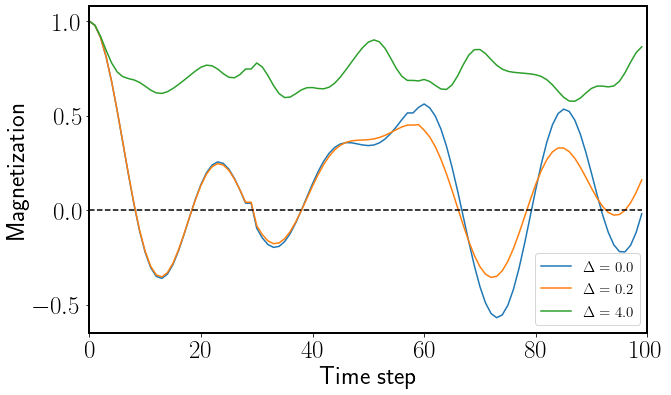

In [8]:
#plt.rcParams['axes.labelsize'] = 15
#plt.rcParams['axes.labelweight'] = 'bold'
#mpl.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 15
#plt.rcParams['font.weight'] = 'bold'
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['font.size'] = 25

#Plot results
fig = plt.figure(figsize=(10,6))
ZR = np.zeros(Nt)
plt.plot(MT[:,0],label='$\Delta = 0.0$')
plt.plot(MT[:,1],label='$\Delta = 0.2$')
plt.plot(MT[:,2],label='$\Delta = 4.0$')
plt.plot(ZR,color='k',linestyle='--')
plt.xlabel('Time step')
plt.ylabel('Magnetization')
plt.xlim(0,Nt)
plt.legend(loc='best')
plt.show()

### Simulating on A Noisy Circuit

Noise added using Pennylane's DepolarizingChannel __[Pennylane](https://pennylane.ai/qml/demos/tutorial_noisy_circuits.html)__. The parameter $p$ is the depolarizing probability.

In [9]:
#Add noise
#Noisy circuit
#p is the depolarizing probability (density matrix transformation due to X, Y or Z gate)
qcdev1 = qml.device("default.mixed", wires=N)
@qml.qnode(qcdev1)
def Noisy_Circuit(p,t,dlt,Wires):
    
    #Initial Neel state
    for i in range(1,N,2):
        qml.PauliX(i)
    
    #Trotter decomposition
    #Apply unitary gates
    n = int(t/dt)
    for i in range(n):
        
        #Hx terms
        for j in range(N-1):
            qml.Hadamard(j)
            qml.Hadamard(j+1)
            qml.CNOT(wires=[j,j+1])
            qml.RZ((2.0*dt/hbar), wires=j+1)
            qml.CNOT(wires=[j,j+1])
            qml.Hadamard(j)
            qml.Hadamard(j+1)
                        
        #Hy terms
        for j in range(N-1):
            qml.RX(-np.pi/2, wires=j)
            qml.RX(-np.pi/2, wires=j+1)
            qml.CNOT(wires=[j,j+1])
            qml.RZ((2.0*dt/hbar), wires=j+1)
            qml.CNOT(wires=[j,j+1])
            qml.RX(np.pi/2, wires=j)
            qml.RX(np.pi/2, wires=j+1)
        
        #Hz terms
        for j in range(N-1):
            qml.CNOT(wires=[j,j+1])
            qml.RZ((2.0*dlt*dt/hbar), wires=j+1)
            qml.CNOT(wires=[j,j+1])
    
    #Add errors
    for k in range(N):
        qml.DepolarizingChannel(p, wires=k)
        
    #Expected value
    indx = Wires[0]
    return qml.expval(qml.PauliZ(indx))

wires = [0]
print(Noisy_Circuit(0.25,1.0,0.0,Wires=wires)) 

0.03994607858181304


In [10]:
#Magnetization function for noisy circuit
#Inputs: error probability p, times t, and delta parameter dlt
def NoisyMgz(p,t,dlt):
    
    mgz = 0.0
    for i in range(N):
        wrs = [i]
        mgz += ((-1.0)**i)*Noisy_Circuit(p,t,dlt,Wires=wrs)
        
    return mgz/N

print(NoisyMgz(0.25,1.0,0.0))

0.14469656809535245


In [12]:
#Magnetization curve for delta = 0.2
delta = 0.2
Ps = [0.1,0.5,0.8] #Error probability
Lp = len(Ps)
MT1 = np.zeros((Nt,Lp))
for i in range(Lp):
    for j in range(Nt):
        MT1[j,i] += NoisyMgz(Ps[i],ts[j],delta)

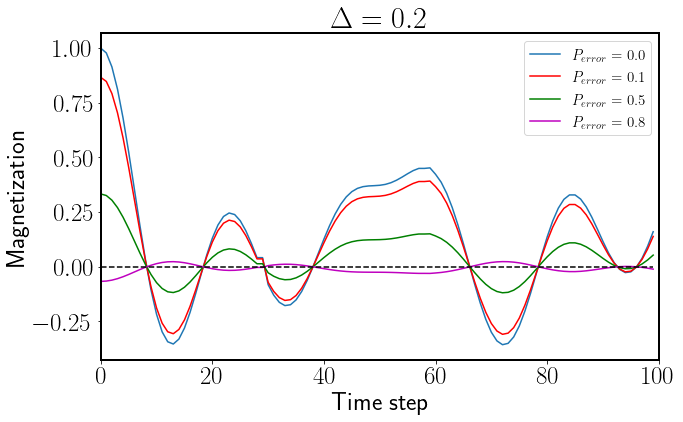

In [14]:
#Plot results
fig = plt.figure(figsize=(10,6))
ZR = np.zeros(Nt)
plt.plot(MT[:,1],label='$P_{error} = 0.0$')
plt.plot(MT1[:,0],color='r',label='$P_{error} = 0.1$')
plt.plot(MT1[:,1],color='g',label='$P_{error} = 0.5$')
plt.plot(MT1[:,2],color='m',label='$P_{error} = 0.8$')
plt.plot(ZR,color='k',linestyle='--')
plt.xlabel('Time step')
plt.ylabel('Magnetization')
plt.title('$\Delta = 0.2$')
plt.xlim(0,Nt)
plt.legend(loc='best')
plt.show()

<!--bibtex

@article{Barmettler2010,
	doi = {10.1088/1367-2630/12/5/055017},
	url = {https://doi.org/10.1088/1367-2630/12/5/055017},
	year = 2010,
	month = {may},
	publisher = {{IOP} Publishing},
	volume = {12},
	number = {5},
	pages = {055017},
	author = {Barmettler, Peter and Matthias Punk and Vladimir Gritsev and Eugene Demler and Ehud Altman},
    title = {Quantum quenches in the anisotropic spin-$\frac{1}{2}$ Heisenberg chain: different approaches to many-body dynamics far from equilibrium},
	journal = {New Journal of Physics},
}

@book{MikeIke,
    title = {Quantum Computation and Quantum Information},
    author = {Nielsen, Michael A. and Chuang, Issac L},
    year = {2010},
    publisher = {Cambridge University Press}
}

@misc{Bassman,
      title={Simulating Quantum Materials with Digital Quantum Computers}, 
      author={Bassman, Lindsay and Miroslav Urbanek and Mekena Metcalf and Jonathan Carter and Alexander F. Kemper and Wibe de Jong},
      year={2021},
      eprint={2101.08836},
      archivePrefix={arXiv},
      primaryClass={quant-ph}
}

-->

# References

<a name="cite-Barmettler2010"/><sup>[^](#ref-1) </sup>Barmettler, Peter and Matthias Punk and Vladimir Gritsev and Eugene Demler and Ehud Altman. 2010. _Quantum quenches in the anisotropic spin-$\frac12$ Heisenberg chain: different approaches to many-body dynamics far from equilibrium_. [URL](https://doi.org/10.1088/1367-2630/12/5/055017)

<a name="cite-MikeIke"/><sup>[^](#ref-2) [^](#ref-4) </sup>Nielsen, Michael A. and Chuang, Issac L. 2010. _Quantum Computation and Quantum Information_.

<a name="cite-Bassman"/><sup>[^](#ref-3) </sup>Bassman, Lindsay and Miroslav Urbanek and Mekena Metcalf and Jonathan Carter and Alexander F. Kemper and Wibe de Jong. 2021. _Simulating Quantum Materials with Digital Quantum Computers_.

